In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

2023-06-13 18:01:04.237186: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 18:01:04.239511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 18:01:04.283038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 18:01:04.283923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 18:01:05.017554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
inpDir = 'input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'
altName="cnn_do"
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 10 # number of epochs
ALPHA = 0.1 # learning rate
BATCH_SIZE = 32 # other sizes leave last batch partial
LR_PATIENCE=2
FACTOR_LR=0.5
PATIENCE = 4
# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

In [3]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
def fn_verify_dir(_path : str):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(_path, ' exists') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print("Created folder : ", _path)

In [5]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [6]:
train,test=tf.keras.datasets.cifar10.load_data()

In [7]:
images,labels=train

unique_elements,counts=np.unique(labels,return_counts=True)

#Print the unique elemnts and their counts
for element,count in zip(unique_elements,counts):
    print(f"{element}:{count}")

0:5000
1:5000
2:5000
3:5000
4:5000
5:5000
6:5000
7:5000
8:5000
9:5000


In [8]:
images,labels=test

unique_elements,counts=np.unique(labels,return_counts=True)

#Print the unique elemnts and their counts
for element,count in zip(unique_elements,counts):
    print(f"{element}:{count}")

0:1000
1:1000
2:1000
3:1000
4:1000
5:1000
6:1000
7:1000
8:1000
9:1000


In [9]:
train_ds=tf.data.Dataset.from_tensor_slices(train)
train_ds=train_ds.batch(BATCH_SIZE)

test_ds=tf.data.Dataset.from_tensor_slices(test)
test_ds=test_ds.batch(BATCH_SIZE)

Verify the data

In [10]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]


2023-06-13 18:01:07.869371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000,1]
	 [[{{node Placeholder/_1}}]]


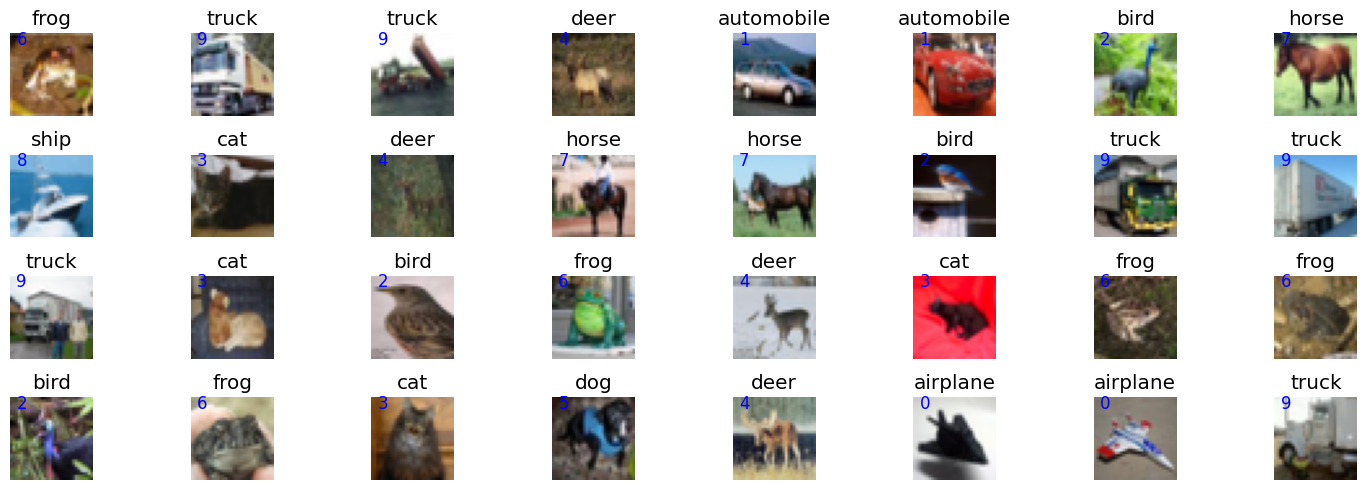

In [11]:
fig=plt.figure(figsize=(15,5))
for images,labels in train_ds.take(1):                 # Batch=1
    for i in range (BATCH_SIZE):
        ax=fig.add_subplot(int(BATCH_SIZE/8),8,i+1 )
        ax.grid(False)
        ax.imshow(images[i].numpy().astype("uint8"),cmap=plt.cm.binary)
        ax.set_title(class_names[labels[i].numpy().squeeze()])
        ax.text(2,4,labels[i].numpy().squeeze(),color="b",fontsize=12)
        ax.axis("off")
    plt.tight_layout()
    plt.show()
        
    

Rescaling of images

In [12]:
normaliztion_layer=tf.keras.layers.Rescaling(1./255)
image_batch,labels_batch=next(iter(train_ds))
img=image_batch[0].numpy()
print("Original Image --- Min pixel:",img.min(),"|Max Pixel:",img.max())
print("-"*50)

#apply it to the dataset by calling map
normalized_ds=train_ds.map(lambda x,y:(normaliztion_layer(x),y))
image_batch,labels_batch=next(iter(normalized_ds))
img=image_batch[0].numpy()
print("Original Image --- Min pixel:",img.min(),"|Max Pixel:",img.max())
print("-"*50)

Original Image --- Min pixel: 0 |Max Pixel: 255
--------------------------------------------------
Original Image --- Min pixel: 0.0 |Max Pixel: 1.0
--------------------------------------------------


2023-06-13 18:01:09.438539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000,1]
	 [[{{node Placeholder/_1}}]]
2023-06-13 18:01:09.481434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000,1]
	 [[{{node Placeholder/_1}}]]


In [13]:
#optimize for performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Convolution Layer in Action

In [14]:
# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Rescaling(1./255) )

# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(32, 32, 3))) # (32 x 32 x 32)
# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (16 x 16 x 32)




# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 padding='same',
                                 activation='relu')) # (16 x 16 x 64)
# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 8 x 8 x 64)




# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 padding='same',
                                 activation = 'relu' ) ) # ( 8 x 8 x 128)
# Pool 3
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 4 x 4 x 128)

In [15]:
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(512,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dense 2
model.add(tf.keras.layers.Dense(64,
                                activation='relu'))

# Dense 2
model.add(tf.keras.layers.Dense(10))

In [16]:
#Early stopping
early_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

modelFile=os.path.join(modelDir,subDir,altName)
model_callbacks=tf.keras.callbacks.ModelCheckpoint(
    filepath=modelFile,
    monitor= 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = 'auto',
    
)

lr_callback=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    )

In [17]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])
history=model.fit(train_ds,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=test_ds,
                 )
#callbacks=[early_callback,model_callbacks,lr_callback]

Epoch 1/10


2023-06-13 18:01:10.392184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000,1]
	 [[{{node Placeholder/_1}}]]


1563/1563 [==============================] - ETA: 0s - loss: 1.4248 - accuracy: 0.4811

2023-06-13 18:01:33.140624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000,1]
	 [[{{node Placeholder/_1}}]]


1563/1563 [==============================] - 25s 15ms/step - loss: 1.4248 - accuracy: 0.4811 - val_loss: 1.1352 - val_accuracy: 0.5961
Epoch 2/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.9955 - accuracy: 0.6488 - val_loss: 0.9106 - val_accuracy: 0.6777
Epoch 3/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.8266 - accuracy: 0.7109 - val_loss: 0.8515 - val_accuracy: 0.7008
Epoch 4/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.7209 - accuracy: 0.7499 - val_loss: 0.8246 - val_accuracy: 0.7112
Epoch 5/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.6393 - accuracy: 0.7775 - val_loss: 0.8256 - val_accuracy: 0.7185
Epoch 6/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.5760 - accuracy: 0.7991 - val_loss: 0.8773 - val_accuracy: 0.7136
Epoch 7/10
1563/1563 [==============================] - 24s 15ms/step - loss: 0.5220 - accuracy: 0.8177 - val_loss: 0.9857 - val_accura

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         7

In [19]:
test_loss,test_acc=model.evaluate(test_ds,verbose=2)

313/313 - 2s - loss: 1.1392 - accuracy: 0.6958 - 2s/epoch - 6ms/step


In [20]:
y_test= tf.concat([y for x,y in test_ds],axis=0).numpy()

In [21]:
yhat= model.predict(test_ds)
y_pred=yhat.argmax(axis=1)
print(f"Accuracy Score on Test Data:{accuracy_score(y_test,y_pred):.4f}")

313/313 [==============================] - 2s 6ms/step
Accuracy Score on Test Data:0.6958


In [22]:
res_df = pd.DataFrame(history.history)
res_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.424764,0.48114,1.135202,0.5961
1,0.995550,0.64882,0.910632,0.6777
2,0.826608,0.71090,0.851494,0.7008
3,0.720857,0.74992,0.824645,0.7112
4,0.639347,0.77754,0.825593,0.7185


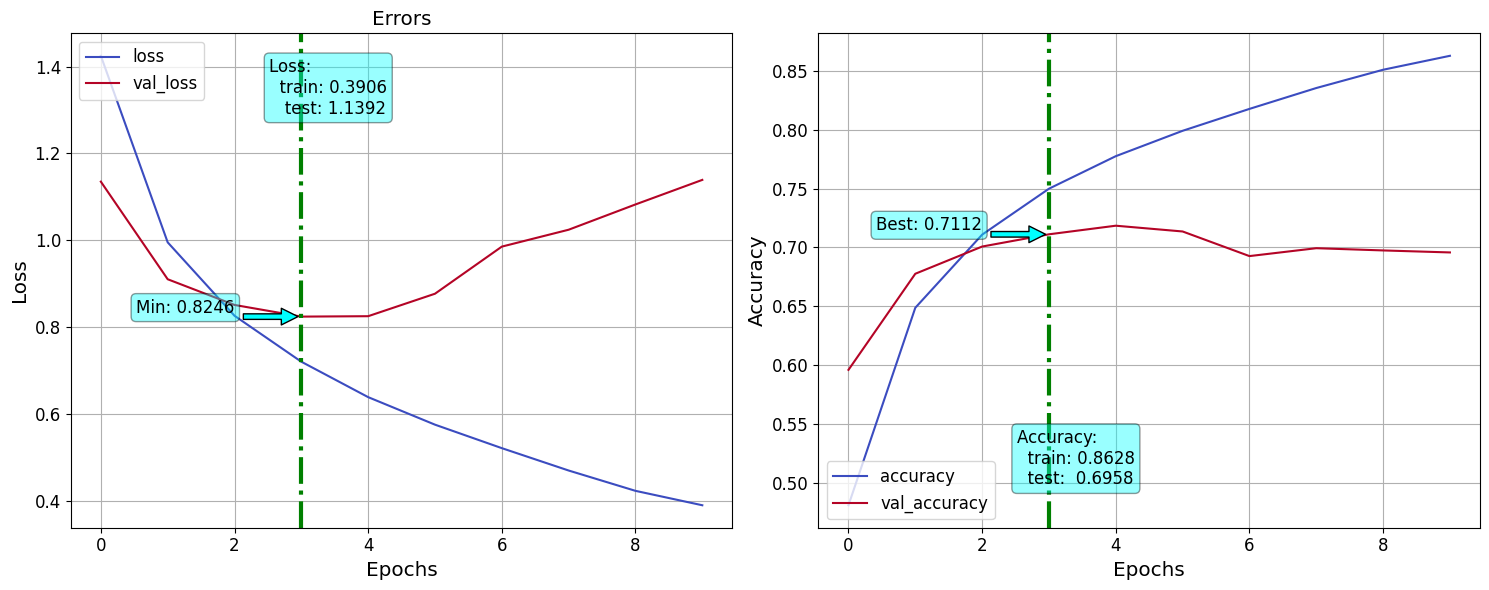

In [23]:
fn_plot_tf_hist(res_df)